## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

**Наши константы**

In [2]:
days_for_out = 30   # Если студент не заходил столько дней, то мы считаем, что он ушел.
days_for_predict = 3    # Количество дней с начала курса, за которое мы ходим предсказать действия нашего студента.

# Поработаем с данными.
### Сперва импортируем их.

In [3]:
events_data = pd.read_csv('event_data_train.csv')

In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [5]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [6]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


**Такие действия может совершать наш пользователь:**

In [7]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

**Добавим человеческие дату и время. Мы же не роботы.**

In [8]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [9]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [10]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [11]:
events_data['day'] = events_data.date.dt.date

In [12]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


**Посмотрим на прирост новых студентов по дням.**

<AxesSubplot:xlabel='day'>

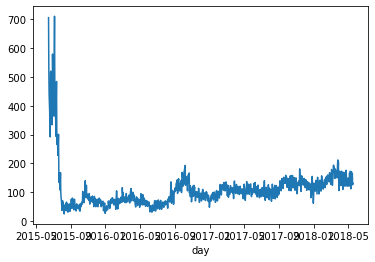

In [13]:
events_data.groupby('day') \
    .user_id.nunique().plot()

**У нас данные за первые 3 года курса. Поэтому в первые дни такой ажиотаж.**

**Создадим дополнительную таблицу с данными о количестве каждого совершенного действия студентами.**

In [14]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [15]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


**Создадим еще одну дополнительную таблицу с данными о правильных и неправильных ответах студентов.**

In [16]:
users_scores = submissions_data.pivot_table(index='user_id',
                             columns='submission_status',
                             values='step_id',
                             aggfunc='count',
                             fill_value=0).reset_index()

In [17]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### Теперь нам нужно понять, после скольких дней отсутствия, мы можем считать, что наш студент дропнулся.

**Для этого возьмем вот такой сабсет.**

In [18]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


**Cгруппируем его по User_id**

In [19]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

**И, собственно, вычислим промежутки между действиями (в секундах)**

In [20]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

**Завернем все это добро в нампай серию и переведем в дни.**

In [21]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [22]:
gap_data = pd.Series(np.concatenate(gap_data,axis=0))

In [23]:
gap_data = gap_data / (24 * 60 * 60)

<AxesSubplot:>

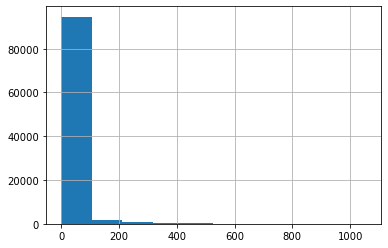

In [24]:
gap_data.hist()

**Не очень-то содержательно.. Большие выбросы. Посмотрим ближе.**

<AxesSubplot:>

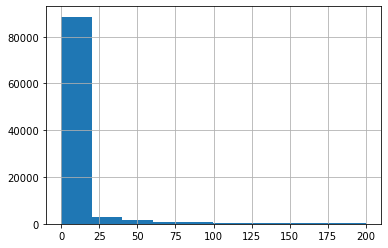

In [25]:
gap_data[gap_data < 200].hist()

**Уже лучше. Глянем квантили.**

In [26]:
gap_data.quantile(0.95)

59.760440972222156

In [27]:
gap_data.quantile(0.90)

18.325995370370403

**Вычислим по айпи дропнувшихся студентов. Но не забудем учесть тех, у кого не прошло 30 дней с момента последнего действия до последней записи в датасете.**

In [28]:
# Находим время последнего действия.
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

**Парочка констант, но так будет удобнее.**

In [29]:
now = events_data.timestamp.max()    # Время последнего действия в ДС
drop_out_threshold = days_for_out * 24 * 60 * 60    # Тот же временной отрезок в секундах для timestamp.

**Заведем новую колонку в нашей таблице с данными о юзерах, в которой укажем дропнулся студент или нет.**

In [30]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

**Смержим с данными об ответах. Не забудем указать тип соединения как "внешнее", чтобы не потерять данные.**

In [31]:
users_data = users_data.merge(users_scores, how='outer')

In [32]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


**И правильно сделали. Могли бы потерять первого же юзера, который, кстати, дропнулся. В итоге вся наша статистика сломалась бы.**

**Теперь заполним все пустые значения нулями, добавим сюда же действия юзеров и количество уникальных дней.**

In [33]:
users_data = users_data.fillna(0)

In [34]:
users_data = users_data.merge(users_events_data, how='outer')

In [35]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [36]:
users_data = users_data.merge(users_days, how='outer')

In [37]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


**Не забудем и про тех студентов, кто прошел курс и имеет полное право не заходить больше на курс. Добавим новую колонку с таким критерием.**

In [38]:
users_data['passed_course'] = users_data.passed > 170   # Тут мы определили, что студент считается прошедшим курс, если набрал 170 баллов

In [39]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [40]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


**Небольшая проверка себя.**

In [41]:
100 * 1425 / 17809

8.001572238755685

**8% студентов закончили курс, что не противоречит общей статистике.**

In [42]:
users_data[users_data.passed_course == False].day.median()

1.0

**Студенты, которые дропнулись, в среднем, проучились 1 уникальный день. Такой перекос из-за тех, кто "пробовал" (скорее всего). Можно попробовать их исключить:**

In [43]:
users_data[(users_data.passed_course == False) & (users_data.day > 1)].day.median()

5.0

**А вот столько, в среднем, они пытались. 5 уникальных дней. Мы пытаемся предсказать их поведение за 3 календарных дня. Должно быть достаточно.
А вот столько уникальных дней учатся те, кто заканчивает курс. В среднем:**

In [44]:
users_data[users_data.passed_course == True].day.median()

20.0

**Неплохо.
Теперь узнаем, когда пользователь совершил первое действие на курсе.**

In [45]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [46]:
users_data = users_data.merge(user_min_time, how='outer')

In [47]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


**Теперь из events_data нам нужно получить данные о действиях юзера за то количество первых дней, которое мы задали в условии.**

In [48]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


**Если делать этот фильтр циклом, то потратим очень много времени.
Есть вот такой интересный способ.**

In [49]:
event_data_train = pd.DataFrame()

**Конкатенируем айди нашего юзера и его время в новый столбец с помощью преобразования в строку и конкатенации строк. Это один из вариантов очень сильно сэкономить время.**

In [50]:
events_data['user_time'] = events_data.timestamp.map(str)

In [51]:
learning_time_treshold = days_for_predict * 24 * 60 * 60    # Время в секундах

**Делаем то же, что и выше, только для дедлайна, до которого мы ходим определить дропнется ли студент. Эти данным нам и интересны.
Затем сохраним это дело в новую колонку, опять-таки, для ускорения работы программы.**

In [52]:
user_learning_time_treshold =(user_min_time.min_timestamp + learning_time_treshold).map(str)

In [53]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [54]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

**Как хорошо, что мы можем сравнивать строки :)
Отбираем только нужные нам действия, совершенные за выбранный выше период.
Не будем перезаписывать, чтобы оставить за собой возможность в дальнейшем менять период. Создадим новый датафрейм.**

In [55]:
event_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [56]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340895,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340895,1434600048


In [57]:
event_data_train.groupby('user_id').day.nunique().max()

4

**Это нормально, что мы получили 4 уникальных дня, потому что 3-е суток могут в большинстве случаев включать в себя 4 уникальных дня.**

**То же самое мы делаем с другой таблицей.**

In [58]:
submissions_data['users_time'] = submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

**Наконец-то мы можем начать формировать датафрейм Х и наполнять его фичами.**

In [59]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})

**Запишем количество уникальных степов, которые пользователь попытался решить.**

In [60]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

In [61]:
X = X.merge(steps_tried,on='user_id', how='outer')

**Добавим правильные и неправильные ответы, а также долю правильных ответов.**

In [62]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                           columns='submission_status',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index())

In [63]:
X['correct ratio'] = X.correct / (X.correct + X.wrong)

In [64]:
X = X.merge(event_data_train.pivot_table(index='user_id',
                                               columns='action',
                                               values='step_id',
                                               aggfunc='count',
                                               fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [65]:
X = X.fillna(0)

**Добавим временные колонки. Закончил ли студент курс и покинул ли он его.**

In [66]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], on='user_id', how='outer')

**Отбираем по условию: убираем тех, кто не дропнулся и не получил диплом. То есть уберем тех, кто еще учится.
А останутся студенты, которые прошли курс, либо бросили его.**

In [67]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

**Создадим переменную "y" и передадим в нее "passed_course". Почему именно так? Потому что мы убрали всех, кто еще учится (не прошел курс и не дропнулся). А значит, если человек не прошел курс, то он точно дропнулся**

In [68]:
y = X.passed_course.map(int)

In [69]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [70]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


**Колонка user_id не представляет ценности для нашей будущей модели (звучит логично, ведь они не несет ни какой логики).
 Но и удалять ее не хотелось бы, чтобы удобно анализировать результаты. Перенесем в индексы.**

In [71]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [72]:
X.head()

,days,steps_tried,correct,wrong,correct ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [73]:
X.to_csv(f'X_{days_for_predict}_{days_for_out}.csv')
y.to_csv(f'y_{days_for_predict}_{days_for_out}.csv')